In [12]:
# add path:
data_path = '../DRIVE_dataset/datasets/'

# check if data_path exists:
import os

if not os.path.exists(data_path):
    print("Please update your data path to an existing folder.")
elif not set(["training", "test"]).issubset(set(os.listdir(data_path))):
    print("Please update your data path to the correct folder (should contain train and test folders).")
else:
    print("Congrats! You selected the correct folder :)")

Congrats! You selected the correct folder :)


In [13]:
import os
import numpy as np
import matplotlib.pyplot as plt
import glob
import monai
from PIL import Image
import torch
import random
import torch.nn as nn
from monai.transforms import Transform
from monai.transforms import Compose, Flipd, Rotate90d, RandFlipd, RandRotate90d, RandSpatialCropd
import warnings
warnings.filterwarnings("ignore")
from monai.data import CacheDataset, DataLoader
from IPython.display import display, clear_output

### our modules
from dataset import *
from training import *
from testing import *
####
# Check whether we're using a GPU
if torch.cuda.is_available():
    n_gpus = torch.cuda.device_count()  # Total number of GPUs
    gpu_idx = random.randint(0, n_gpus - 1)  # Random GPU index
    device = torch.device(f'cuda:{gpu_idx}')
    print('Using GPU: {}'.format(device))
else:
    device = torch.device('cpu')
    print('GPU not found. Using CPU.')

Using GPU: cuda:0


In [14]:
train_dict_list = build_dict_vessels(data_path, mode='training')
test_dict_list = build_dict_vessels(data_path, mode='test')
print(test_dict_list)
print(f'Number of samples in the training dataset: {len(train_dict_list)}')

[{'img': '../DRIVE_dataset/datasets/test/images/01_test.tif'}, {'img': '../DRIVE_dataset/datasets/test/images/02_test.tif'}, {'img': '../DRIVE_dataset/datasets/test/images/03_test.tif'}, {'img': '../DRIVE_dataset/datasets/test/images/04_test.tif'}, {'img': '../DRIVE_dataset/datasets/test/images/05_test.tif'}, {'img': '../DRIVE_dataset/datasets/test/images/06_test.tif'}, {'img': '../DRIVE_dataset/datasets/test/images/07_test.tif'}, {'img': '../DRIVE_dataset/datasets/test/images/08_test.tif'}, {'img': '../DRIVE_dataset/datasets/test/images/09_test.tif'}, {'img': '../DRIVE_dataset/datasets/test/images/10_test.tif'}, {'img': '../DRIVE_dataset/datasets/test/images/11_test.tif'}, {'img': '../DRIVE_dataset/datasets/test/images/12_test.tif'}, {'img': '../DRIVE_dataset/datasets/test/images/13_test.tif'}, {'img': '../DRIVE_dataset/datasets/test/images/14_test.tif'}, {'img': '../DRIVE_dataset/datasets/test/images/15_test.tif'}, {'img': '../DRIVE_dataset/datasets/test/images/16_test.tif'}, {'img':

Loading dataset: 100%|██████████| 20/20 [00:00<00:00, 36.34it/s]


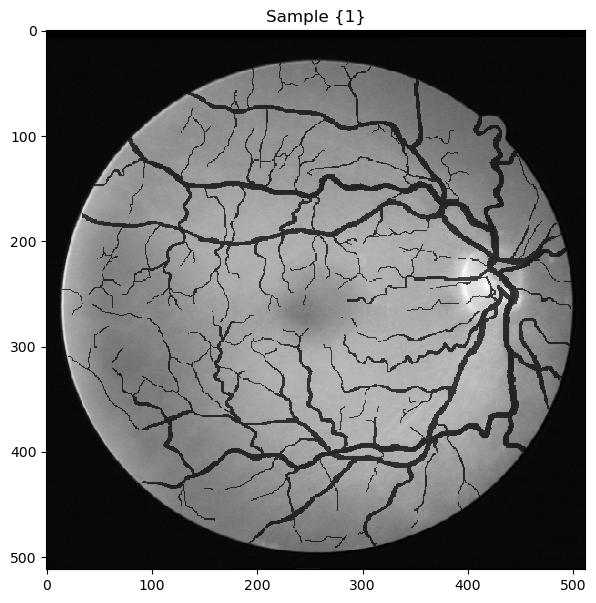

In [15]:
train_dataset = monai.data.CacheDataset(train_dict_list, transform=LoadVesselData())
# visualize first image
visualize_vessel_sample(train_dataset[1], title="Sample {1}")

In [16]:
data_loader = DataLoader(train_dataset, batch_size=5, shuffle=True)

In [17]:
latent_dim = 10 #??

In [18]:
# IMPORT IMAGES FROM VASCUSYNTH
import torchvision
class VascuSynthImageDataset(torch.utils.data.Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.transform = transform
        self.image_files = [f for f in os.listdir(image_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.image_files[idx])
        image = Image.open(img_path).convert("L")  # Converte in scala di grigi
        if self.transform:
            image = self.transform(image)
        return image, 0  # Il secondo valore è un segnaposto per l'etichetta

# Definizione delle trasformazioni
transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((28, 28)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5,), (0.5,))
])

# Carica il dataset
dataset = VascuSynthImageDataset('../VS_images', transform=transform)
data_loader2 = DataLoader(dataset, batch_size=12, shuffle=True)

In [19]:
class Discriminator_MLP(nn.Module):
    
    def __init__(self):
        super(Discriminator_MLP, self).__init__()
        self.layers = nn.Sequential(nn.Linear(in_features=512*512, out_features=1024),
                                   nn.LeakyReLU(0.2),
                                   nn.Dropout(0.3),
                                   nn.Linear(in_features=1024, out_features=512),
                                   nn.LeakyReLU(0.2),                                   
                                   nn.Dropout(0.3),                                   
                                   nn.Linear(in_features=512, out_features=256),
                                   nn.LeakyReLU(0.2),                                   
                                   nn.Linear(in_features=256, out_features=1),
                                   nn.Sigmoid())
       
    
    
    def forward(self, x):
        return self.layers(x)

In [20]:
class Generator_MLP(nn.Module):
    
    def __init__(self):
        super(Generator_MLP, self).__init__()
        self.layers = nn.Sequential(nn.Linear(in_features=latent_dim, out_features=256),
                                    nn.LeakyReLU(0.2),                                    
                                    nn.Linear(in_features=256, out_features=512),                                    
                                    nn.LeakyReLU(0.2),                                    
                                    nn.Linear(in_features=512, out_features=1024), 
                                    nn.LeakyReLU(0.2),                                   
                                    nn.Linear(in_features=1024, out_features=512*512),
                                    nn.Tanh())
    def forward(self, x):
        return self.layers(x).view(-1, 1, 512, 512)  # Rende l'output della stessa forma di real_images   
    #def forward(self, x):
     #   return self.layers(x)

In [21]:
# Get networks
discriminator = Discriminator_MLP()
generator = Generator_MLP()

# Push networks to device
discriminator.to(device)
generator.to(device)

# Configure optimizers and loss function
optimizer_dis = torch.optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_gen = torch.optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
loss = torch.nn.BCELoss()

In [22]:
# Save model checkpoint in a folder called 'saved_models'
def saveModels(epoch, model_name):
    to_save = {
        'epoch': epoch,
        'generator': generator.state_dict(),
        'discriminator': discriminator.state_dict(),
        'optimizer_gen': optimizer_gen.state_dict(),
        'optimizer_dis': optimizer_dis.state_dict()
    }
    directory = os.path.join('saved_models', model_name)
    if not os.path.exists(directory):
        os.makedirs(directory)
    torch.save(to_save, os.path.join(directory, 'Epoch_{}.pt'.format(epoch)))
    
# Plot generated images in a grid
def plotGeneratedImages(epoch, examples=9, dim=(3, 3), figsize=(10, 10)):
    with torch.no_grad():
        noise = torch.normal(0, 1, size=(examples, latent_dim), device=device)
        fake_images = generator(noise).cpu().numpy()
        fake_images = fake_images.reshape(examples, 512, 512)

        fig = plt.figure(figsize=figsize)
        fig.suptitle('Epoch {}'.format(epoch), fontsize=14)
        for i in range(fake_images.shape[0]):
            plt.subplot(dim[0], dim[1], i+1)
            plt.imshow(fake_images[i], interpolation='nearest', cmap='gray_r')
            plt.axis('off')
        plt.tight_layout()
        plt.show()
        return fig

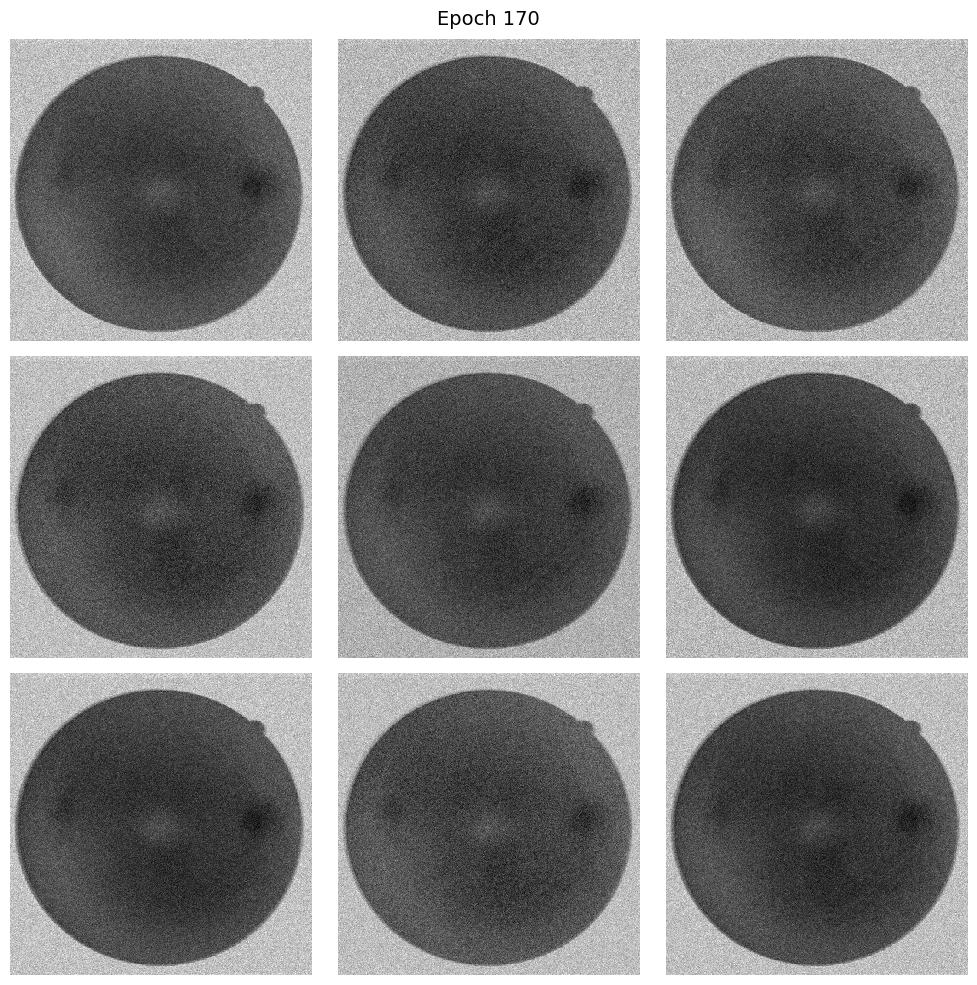

KeyboardInterrupt: 

In [23]:
from tqdm import tqdm
import os

dis_losses = []
gen_losses = []

epochs = 200  ###
batch_size = 5
fig = None

for epoch in range(1, epochs + 1):
    
    # Wrap dataloader into tqdm such that we can print progress while training
    with tqdm(data_loader, unit="iterations") as tqdm_iterator:
        tqdm_iterator.set_description('Epoch {}'.format(epoch))
        
        for i, batch in enumerate(tqdm_iterator):

            # ========== Train Discriminator ==========
            
            # Freeze generator part
            for param in generator.parameters():
                param.requires_grad = False
            for param in discriminator.parameters():
                param.requires_grad = True
            discriminator.zero_grad()

            ########
            # Get a random set of input noise
            noise = torch.normal(0, 1, size=(batch_size, latent_dim), device=device)
            
            ########

            # Get real images and flatten the image dimensions
            real_images = batch['img']
            #print(real_images.shape)
            real_images = real_images.to(device).view(batch_size, 512*512)
            #print(real_images.shape)

            # Generate some fake MNIST images using the generator
            fake_images = generator(noise)
            fake_images = fake_images.to(device).view(batch_size, 512*512)
            #print(fake_images.shape)
            # Concatenate the fake and real images
            dis_input = torch.cat((real_images, fake_images))

            # Labels for generated and real data
            dis_labels = torch.zeros((2 * batch_size, 1), device=device)

            # One-sided label smoothing
            dis_labels[:batch_size] = 0.9 ###

            # Train discriminator with this batch of samples
            predictions = discriminator(dis_input)
            dis_loss = loss(predictions, dis_labels)
            dis_loss.backward()
            optimizer_dis.step()
            dis_losses.append(dis_loss.detach().cpu().numpy())

            # ========== Train Generator ==========
            
            # Freeze the discriminator part
            for param in generator.parameters():
                param.requires_grad = True
            for param in discriminator.parameters():
                param.requires_grad = False
            generator.zero_grad()

            # Train generator with a new batch of generated samples
            noise = torch.normal(0, 1, size=(batch_size, latent_dim), device=device)

            # From the generator's perspective, the discriminator should predict
            # ones for all samples
            gen_labels = torch.ones((batch_size, 1), device=device)

            # Train the GAN to predict ones
            fake_images = generator(noise)
            fake_images = fake_images.to(device).view(batch_size, 512*512)
            predictions = discriminator(fake_images)
            gen_loss = loss(predictions, gen_labels)
            gen_loss.backward()
            optimizer_gen.step()
            gen_losses.append(gen_loss.detach().cpu().numpy())
        
    # Display generated images every 5th epoch
    if epoch % 10 == 0:
        clear_output(wait=True)
        fig = plotGeneratedImages(epoch)
        saveModels(epoch, 'MLP_GAN')

<class 'dict'>
4


KeyError: 0

In [14]:
print(batch.keys())

dict_keys(['img', 'mask', 'img_meta_dict', 'mask_meta_dict'])


In [29]:
print(real_images.shape)

torch.Size([10, 262144])


In [16]:
print(type(real_images)) 

<class 'torch.Tensor'>


In [30]:
print(fake_images.shape)

torch.Size([10, 1, 512, 512])
